In [1]:
#required imports
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from math import sqrt 
from sklearn.metrics import confusion_matrix
import datetime
import warnings
warnings.filterwarnings('ignore')
from dateutil.parser import parse
from datetime import timedelta,datetime,date

FEATURES_FILE="../Data_Preparation/KingsCross_SlidingWindow_48hours.csv"

In [2]:
features = pd.read_csv(FEATURES_FILE)
features["Date"] = features["New Date"]
del features["New Date"]
for c in features.columns:
    print(c)

StartStation Id
Current Usage
Usage0
Usage1
Usage2
Usage3
Usage4
Usage5
Usage6
Usage7
Usage8
Usage9
Usage10
Usage11
Usage12
Usage13
Usage14
Usage15
Usage16
Usage17
Usage18
Usage19
Usage20
Usage21
Usage22
Usage23
Usage24
Usage25
Usage26
Usage27
Usage28
Usage29
Usage30
Usage31
Usage32
Usage33
Usage34
Usage35
Usage36
Usage37
Usage38
Usage39
Usage40
Usage41
Usage42
Usage43
Usage44
Usage45
Usage46
Usage47
Usage 48 Avg. over 6h
Usage 49 Avg. over 6h
Usage 50 Avg. over 6h
Usage 51 Avg. over 6h
Future0
Future1
Future2
Future3
Future4
Future5
Future6
Future7
Future8
Future9
Future10
Future11
Future12
Future13
Future14
Future15
Future16
Future17
Future18
Future19
Future20
Future21
Future22
Future23
Current Temperature
temp0
temp1
temp2
temp3
temp4
temp5
temp6
temp7
temp8
temp9
temp10
temp11
temp12
temp13
temp14
temp15
temp16
temp17
temp18
temp19
temp20
temp21
temp22
temp23
temp24
temp25
temp26
temp27
temp28
temp29
temp30
temp31
temp32
temp33
temp34
temp35
temp36
temp37
temp38
temp39
temp40
temp4

In [3]:
features.head()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind43,wind44,wind45,wind46,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Date
0,14,3,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-04T00:00:00.000+01:00
1,14,0,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-04T01:00:00.000+01:00
2,14,0,0,3,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-04T02:00:00.000+01:00
3,14,0,0,0,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-04T03:00:00.000+01:00
4,14,0,0,0,0,3,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-04T04:00:00.000+01:00


In [4]:
holidays = pd.read_csv("../raw/UK Bank Holidays.csv")
holidays.rename({"Bank Holiday":"Holiday"}, inplace=True)
del holidays["Name"]
holidays.head()

,Bank Holiday,Date
0,1,2009-01-01
1,0,2009-01-25
2,0,2009-01-27
3,0,2009-02-14
4,0,2009-02-24


In [5]:
MARGIN_HOURS = 4 # if 6 from 0:00-6:00 to 24:00-6:00 -> 18:00 to 18:00

# First filling a holidays dictionnary:
holidays_dico = {}
for index, row in holidays.iterrows():
    if row["Bank Holiday"] == 1:
        today = parse(row["Date"])
        holidays_dico[today] = True

# Detect if datetime is in [day - MARGIN_HOURS;day + 1 - MARGIN_HOURS[ :
holiday_array = []
for index, row in features.iterrows():
    now = parse(row["Date"])
    today = datetime(now.year,now.month,now.day)
    if now.hour >= 24 - MARGIN_HOURS:
        today = today + timedelta(1)
    holiday_array.append(holidays_dico.get(today,False))
    
features["Bank Holiday"]  = holiday_array
features[features["Bank Holiday"] == True].head()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind44,wind45,wind46,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Date,Bank Holiday
2146,14,3,5,5,7,8,2,4,10,8,...,5.79,7.20,7.10,7.26,7.665000,7.491667,6.065000,6.425000,2015-04-02T20:00:00.000+02:00,True
2147,14,1,3,5,5,7,8,2,4,10,...,5.29,5.79,7.20,7.10,7.213333,7.881667,5.966667,6.258333,2015-04-02T21:00:00.000+02:00,True
2148,14,2,1,3,5,5,7,8,2,4,...,5.91,5.29,5.79,7.20,6.861667,7.841667,6.408333,6.006667,2015-04-02T22:00:00.000+02:00,True
2149,14,2,2,1,3,5,5,7,8,2,...,6.26,5.91,5.29,5.79,6.356667,7.993333,6.603333,5.891667,2015-04-02T23:00:00.000+02:00,True
2150,14,0,2,2,1,3,5,5,7,8,...,5.59,6.26,5.91,5.29,5.988333,7.945000,6.781667,6.015000,2015-04-03T00:00:00.000+02:00,True


In [6]:
def parse_date(s):
    a = s.split("T")[0].split("-")
    return datetime(int(a[0]),int(a[1]),int(a[2]))
features["Month"] = features["Date"].map(lambda x: parse_date(x).month)
features["Weekday"] = features["Date"].map(lambda x: parse_date(x).weekday())
del features["Date"]

In [7]:
from collections import defaultdict
cleanup_nums = {"clear-day": 1, "clear-night": 1, "partly-cloudy-day": 2, "partly-cloudy-night": 2,"cloudy":3,"wind":4, "rain": 5, "fog": 6, "snow": 7, "sleet": 7, 'nan': 1}
cleanup_nums = defaultdict(lambda: 1, cleanup_nums)
for i in range(48):
    features["sum" + str(i)] = features["sum" + str(i)].map(lambda x: cleanup_nums[x])

features["Current Summary"] = features["Current Summary"].map(lambda x: cleanup_nums[x])
features["sum0"].head()

0    1
1    2
2    2
3    6
4    1
Name: sum0, dtype: int64

In [8]:
features = features.fillna(0)

In [9]:
features.tail()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind45,wind46,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Bank Holiday,Month,Weekday
36919,14,6,5,7,5,6,6,5,6,16,...,10.76,12.93,14.00,8.693333,9.183333,8.786667,11.740000,False,3,1
36920,14,9,6,5,7,5,6,6,5,6,...,11.79,10.76,12.93,7.815000,9.318333,8.691667,10.886667,False,3,1
36921,14,1,9,6,5,7,5,6,6,5,...,10.80,11.79,10.76,6.826667,9.555000,8.771667,10.181667,False,3,1
36922,14,5,1,9,6,5,7,5,6,6,...,10.16,10.80,11.79,5.818333,9.761667,8.961667,9.666667,False,3,1
36923,14,3,5,1,9,6,5,7,5,6,...,8.88,10.16,10.80,5.170000,9.670000,8.833333,9.350000,False,3,1


In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36924 entries, 0 to 36923
Columns: 289 entries, StartStation Id to Weekday
dtypes: bool(1), float64(163), int64(125)
memory usage: 81.2 MB


In [11]:
features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
StartStation Id,36924.0,14.000000,0.000000,14.0,14.000000,14.000000,14.000000,14.00
Current Usage,36924.0,10.774212,26.036247,0.0,1.000000,3.000000,8.000000,292.00
Usage0,36924.0,10.773318,26.036581,0.0,1.000000,3.000000,8.000000,292.00
Usage1,36924.0,10.775214,26.035854,0.0,1.000000,3.000000,8.000000,292.00
Usage2,36924.0,10.773562,26.036474,0.0,1.000000,3.000000,8.000000,292.00
Usage3,36924.0,10.773318,26.036549,0.0,1.000000,3.000000,8.000000,292.00
Usage4,36924.0,10.776812,26.035342,0.0,1.000000,3.000000,8.000000,292.00
Usage5,36924.0,10.775864,26.035752,0.0,1.000000,3.000000,8.000000,292.00
Usage6,36924.0,10.777706,26.035128,0.0,1.000000,3.000000,8.000000,292.00
Usage7,36924.0,10.777976,26.035058,0.0,1.000000,3.000000,8.000000,292.00


In [12]:
#Feature Matrix with past and today data
cols = features.columns
cols = filter(lambda x: x[:6] != "Future", cols)
X=features.loc[:,cols]
X.head()

,StartStation Id,Current Usage,Usage0,Usage1,Usage2,Usage3,Usage4,Usage5,Usage6,Usage7,...,wind45,wind46,wind47,wind 48 Avg. over 6h,wind 49 Avg. over 6h,wind 50 Avg. over 6h,wind 51 Avg. over 6h,Bank Holiday,Month,Weekday
0,14,3,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,6
1,14,0,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,6
2,14,0,0,3,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,6
3,14,0,0,0,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,6
4,14,0,0,0,0,3,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,6


In [13]:
y_tests = []
preds = []

for i in range(24):
    print(i)
    #target variable
    y = features['Future' + str(i)].tolist()
    #Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mlp = MLPRegressor(
    hidden_layer_sizes=(10,5),  activation='relu', solver='lbfgs', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    m = mlp.fit(X_train_scaled,y_train)
    predictions = m.predict(X_test_scaled)
    
    y_tests.append(y_test)
    preds.append(predictions)
    
    #Print scores
    print("Training set score: %f" % m.score(X_train_scaled, y_train))
    print("Test set score: %f" % m.score(X_test_scaled, y_test))
    
    #Compare predicted and actual values
    #df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})  
    #print(df.head())


0
Training set score: 0.970107
Test set score: 0.907214
1
Training set score: 0.961687
Test set score: 0.816899
2
Training set score: 0.958114
Test set score: 0.793470
3
Training set score: 0.951565
Test set score: 0.760999
4
Training set score: 0.951627
Test set score: 0.744166
5
Training set score: 0.954874
Test set score: 0.722847
6
Training set score: 0.943515
Test set score: 0.718290
7
Training set score: 0.933130
Test set score: 0.692533
8
Training set score: 0.937760
Test set score: 0.750777
9
Training set score: 0.949155
Test set score: 0.655800
10
Training set score: 0.927041
Test set score: 0.628916
11
Training set score: 0.954825
Test set score: 0.622217
12
Training set score: 0.948580
Test set score: 0.700656
13
Training set score: 0.930104
Test set score: 0.676384
14
Training set score: 0.934563
Test set score: 0.651577
15
Training set score: 0.948550
Test set score: 0.672666
16
Training set score: 0.937645
Test set score: 0.658058
17
Training set score: 0.945257
Test set 

<BarContainer object of 24 artists>

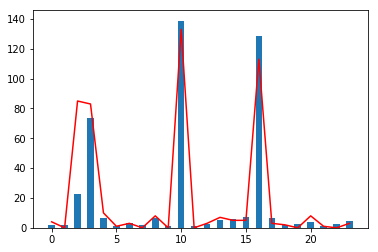

In [20]:
plt.plot(list(range(24)),list(map(lambda x:x[0],y_tests)), color="red")
plt.bar(list(range(24)),list(map(lambda x:x[0],preds)), 0.5)

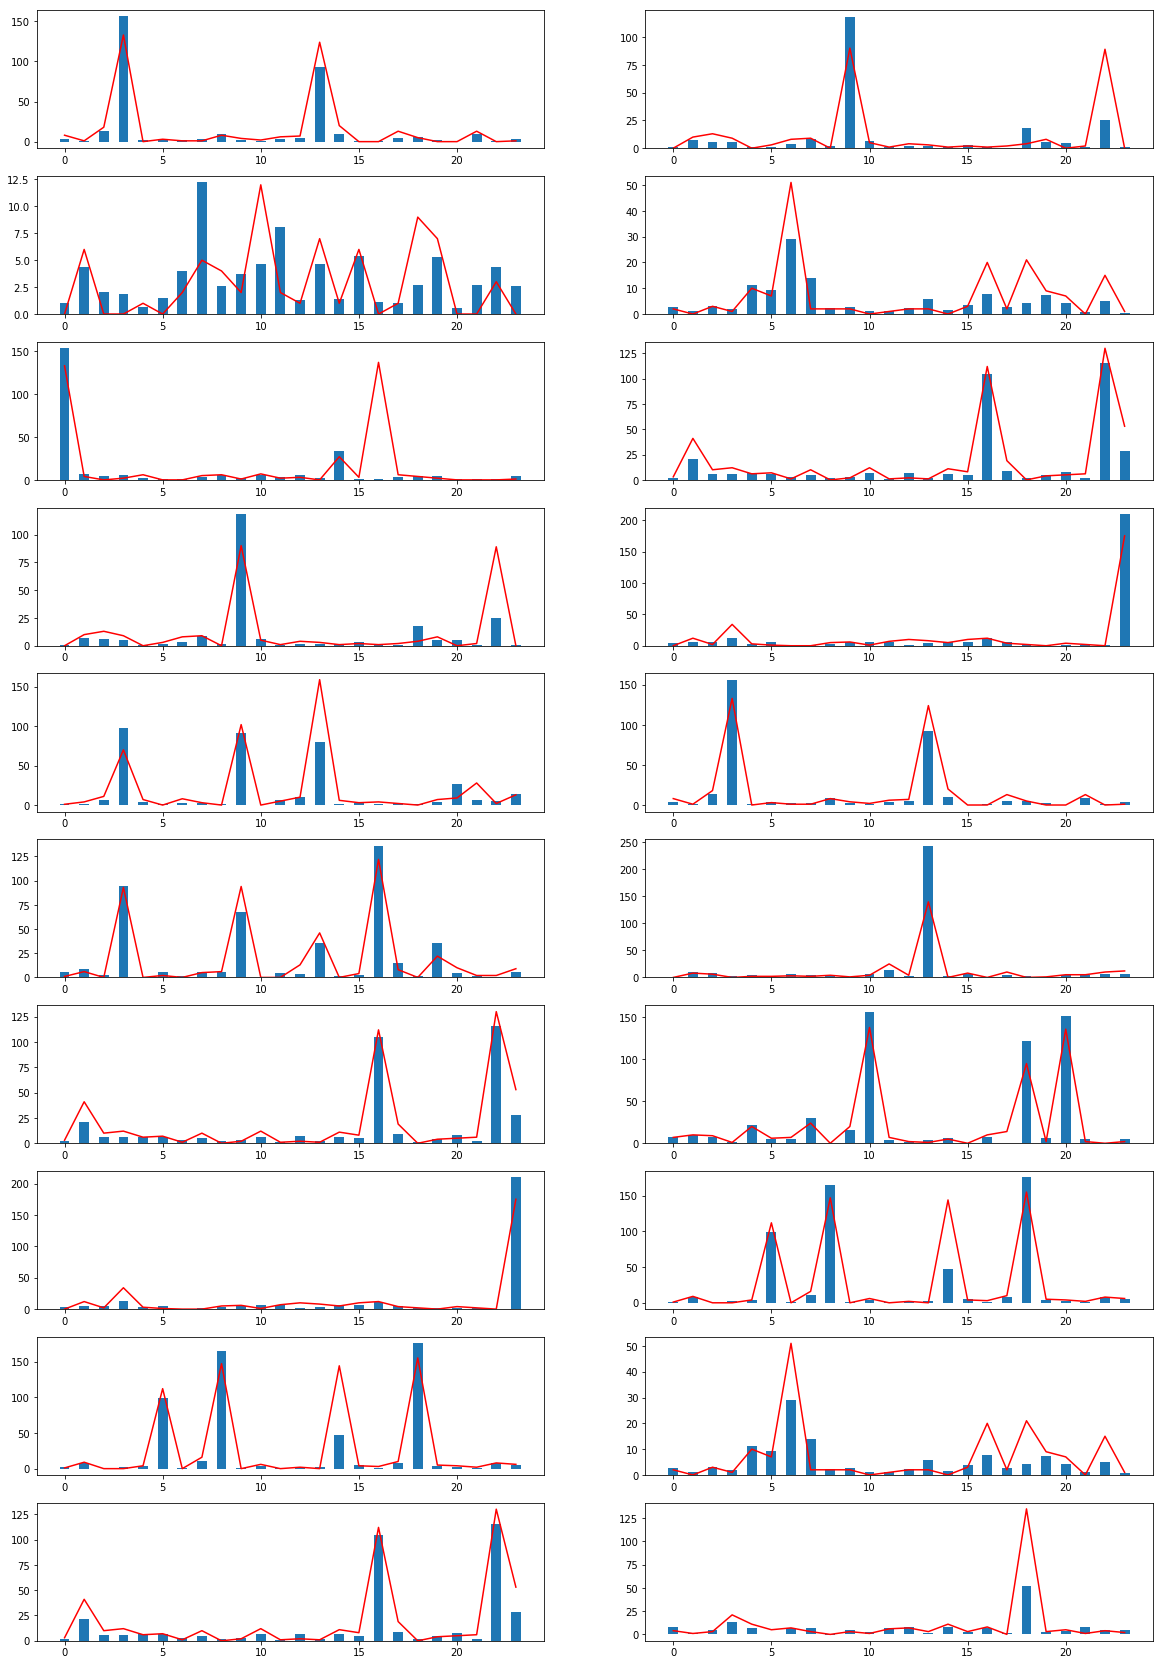

In [15]:
from random import randrange
length = 20
width = 2
height = length / width + length % width

plt.figure(figsize=(20,30))

for i in range(length):
    j = randrange(len(y_tests))
    plt.subplot(height, width, i + 1)
    plt.plot(list(range(24)),list(map(lambda x:x[j],y_tests)), color="red")
    plt.bar(list(range(24)),list(map(lambda x:x[j],preds)), 0.5)

plt.show() 

## Accuracy
Recommended from [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)<br>
```python
score(X, y, sample_weight=None)
```
Returns the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.


In [16]:
#Returns the coefficient of determination R^2 of the prediction
"The accuracy of the model is {0:.7f}".format(mlp.score(X_train_scaled,y_train))

'The accuracy of the model is 0.9482518'

## RMSE = Root Mean Square Error 
is a frequently used measure of the differences between values predicted by a model. 

It is the standard deviation of prediction errors.<br>
[RMSE](https://www.statisticshowto.datasciencecentral.com/rmse/) answers the question of how concentrated the data is around the line of best fit.
![](img/rmse.png)
Where:<br>
f = forecasts (expected values or unknown results)<br>
o = observed values (known results)

In [17]:
#RMSE version 1
a=df.loc[:,'Actual']
b=df.loc[:,'Predicted']
rmse=sqrt(mean_squared_error(a, b))  
"The root mean square error of the model is {0:.3f}".format(rmse) 

NameError: name 'df' is not defined

In [ ]:
#RMSE version 2
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse = rmse(a,b)
"The root mean square error of the model is {0:.3f}".format(rmse)

In [ ]:
fig = plt.figure(figsize=(26,8))
plt.subplot(121)
plt.scatter(X_train.values[:,4], y_train, color = 'blue',label='Actual Value') 
plt.scatter(X_test.values[:,4], y_test, color = 'red',label='Predicted Value') 
plt.legend()
plt.yticks(np.arange(0, 1000, step=100))
plt.title("MLPRegressor Testdata")
plt.ylabel("Frequency")
plt.xlabel("Daily Wheater")
plt.show() 
fig.savefig('img/mlpDaily.png')

In [ ]:
fig = plt.figure(figsize=(26,8))
plt.subplot(121)
plt.scatter(X_train.values[:,7], y_train, color = 'blue',label='Actual Value') 
plt.scatter(X_test.values[:,7], y_test, color = 'red',label='Predicted Value') 
plt.legend()
plt.yticks(np.arange(0, 1000, step=100))
plt.title("MLPRegressor Testdata")
plt.ylabel("Frequency")
plt.xlabel("Windspeed")
plt.show() 
fig.savefig('img/mlpWindspeed.png')

In [ ]:
fig = plt.figure(figsize=(26,8))
plt.subplot(121)
plt.scatter(X_train.values[:,9], y_train, color = 'blue',label='Actual Value') 
plt.scatter(X_test.values[:,9], y_test, color = 'red',label='Predicted Value') 
plt.legend()
plt.yticks(np.arange(0, 1000, step=100))
plt.title("MLPRegressor Testdata")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show() 
fig.savefig('img/mlpTemp.png')